In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [2]:
def posterior_predictive(X, y, sigma_y, kernel, X_star):
    K = np.zeros((X.shape[0], X.shape[0]))
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            K[i, j] = kernel(X[i], X[j])
    K += sigma_y**2 * np.eye(X.shape[0])
    
    K_star = np.zeros((X.shape[0], X_star.shape[0]))
    for i in range(X.shape[0]):
        for j in range(X_star.shape[0]):
            K_star[i, j] = kernel(X[i], X_star[j])
    
    K_star_star = np.zeros((X_star.shape[0], X_star.shape[0]))
    for i in range(X_star.shape[0]):
        for j in range(X_star.shape[0]): #note: could be made more efficient using K's symmetry
            K_star_star[i, j] = kernel(X_star[i], X_star[j])
    
    posterior_mean = K_star.T @ np.linalg.inv(K) @ f
    posterior_cov = K_star_star - K_star.T @ np.linalg.inv(K) @ K_star
    
    return posterior_mean, posterior_cov

In [3]:
def sq_exp_kernel(sigma=1, l=1):
    """
    l determines the length of the 'wiggles' in your function. 
    You won't be able to extrapolate more than l units away from your data.
    sigma determines the average distance of your function away from its mean.
    """
    return lambda x1, x2: sigma**2 * np.exp(-np.dot((x1 - x2), (x1 - x2)) / (2 * l**2))

In [5]:
def plot_GP(X, f, mu_star, sigma_star):
    plt.scatter(X, f, c='red', label='X')
    sigma = sigma_star.diagonal()
    plt.fill_between(X_star, (mu_star - sigma), (mu_star + sigma), alpha=.5, label='sigma')
    plt.plot(X_star, mu_star, label='mu_star')
    plt.legend(loc=3, bbox_to_anchor=(0., 1.02, 1., .102), mode='expand')
    plt.show()

## Test Data

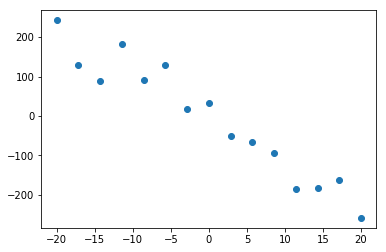

In [4]:
order = 2
X = np.linspace(-20, 20, 15)
partials = np.random.randn(15)
genweights = 10 * np.random.randn(order)
def poly(i):
    return (genweights.T @ np.array([i**p for p in range(order)]) 
            + 10 * order**order * np.random.randn())
polyfunc = np.vectorize(poly)
f = polyfunc(X)
plt.scatter(X, f)

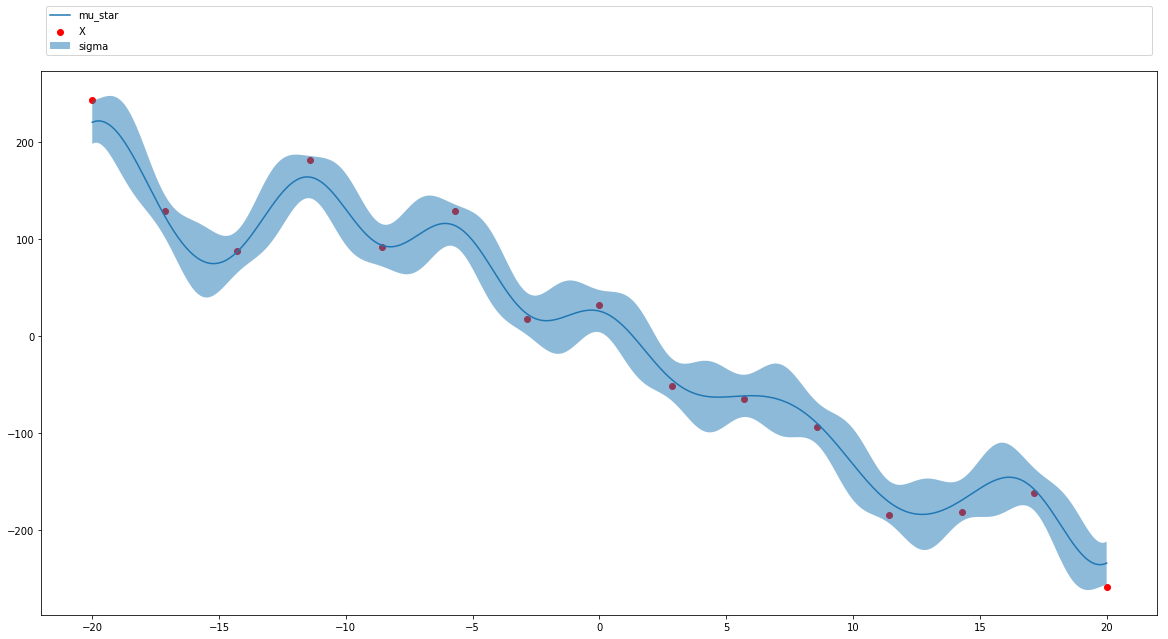

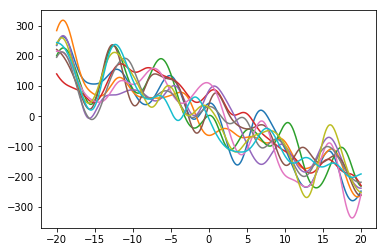

In [39]:
sigma_y = np.ones(15) * 5
X_star = np.linspace(-20, 20, 500)
mu_star, sigma_star = posterior_predictive(X, f, sigma_y, sq_exp_kernel(sigma=15, l=2), X_star)
plt.figure(figsize=(20,10))
plot_GP(X, f, mu_star, sigma_star)

In [ ]:
plt.figure(figsize=(20, 10))

# sample from posterior predictive
for i in range(10):
    plt.plot(X_star, np.random.multivariate_normal(mean=mu_star, cov=50*sigma_star))